# Modeling using Time Series

---

### Import Libraries

In [10]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
%load_ext autoreload
%autoreload 2

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error


In [12]:
from tools.tools import read_json, get_current_time

In [13]:
plt.style.use('ggplot')

In [14]:
config = read_json('../config.json')

current_date = get_current_time('yyyymmdd')

wd = f"{config['workspace_directory']}/data"

In [80]:
df = pd.read_csv(f"{wd}/processing/basin_int_viirs_for_modeling.csv")

In [83]:
df = df[df['region'] == 'Permian Region']

In [84]:
df['year_month'] = pd.to_datetime(df['year_month']).dt.to_period('M')
df.set_index('year_month', inplace=True)
df.sort_index(inplace=True)  # sort by datetime just to be safe

/Users/danielmsheehan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [85]:
df.shape

(97, 83)

In [86]:
df

,region,latest_day_in_month,obs_day_cnt_avg,obs_day_cnt_med,obs_day_cnt_sum,obs_day_cnt_min,obs_day_cnt_max,qf_fit_day_avg_avg,qf_fit_day_avg_med,qf_fit_day_avg_sum,...,obs_day_cnt_avg_over_pct_month_completed,obs_day_cnt_med_over_pct_month_completed,obs_day_cnt_sum_over_pct_month_completed,obs_day_cnt_min_over_pct_month_completed,obs_day_cnt_max_over_pct_month_completed,obs_day_cnt_avg_per_squaremeters_over_pct_month_completed,obs_day_cnt_med_per_squaremeters_over_pct_month_completed,obs_day_cnt_sum_per_squaremeters_over_pct_month_completed,obs_day_cnt_min_per_squaremeters_over_pct_month_completed,obs_day_cnt_max_per_squaremeters_over_pct_month_completed
year_month,,,,,,,,,,,,,,,,,,,,,
2012-03,Permian Region,2012-03-31,50.964286,48.0,1427,12,112,1.807258,1.488728,50.603236,...,50.964286,48.000000,1427.000000,12.0,112.000000,2.405388e-10,2.265481e-10,6.735085e-09,5.663702e-11,5.286122e-10
2012-04,Permian Region,2012-04-30,54.833333,53.5,1645,7,144,2.090061,1.270513,62.701818,...,54.833333,53.500000,1645.000000,7.0,144.000000,2.587997e-10,2.525067e-10,7.763991e-09,3.303826e-11,6.796442e-10
2012-05,Permian Region,2012-05-31,80.689655,76.0,2340,8,202,3.002493,2.513158,87.072283,...,80.689655,76.000000,2340.000000,8.0,202.000000,3.808351e-10,3.587011e-10,1.104422e-08,3.775801e-11,9.533898e-10
2012-06,Permian Region,2012-06-30,94.758621,86.0,2748,22,288,2.691639,2.611111,78.057527,...,94.758621,86.000000,2748.000000,22.0,288.000000,4.472371e-10,4.058986e-10,1.296988e-08,1.038345e-10,1.359288e-09
2012-07,Permian Region,2012-07-31,65.225806,63.0,2022,2,134,2.393206,2.352941,74.189378,...,65.225806,63.000000,2022.000000,2.0,134.000000,3.078496e-10,2.973443e-10,9.543337e-09,9.439503e-12,6.324467e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11,Permian Region,2019-11-30,331.607143,326.5,9285,2,659,3.951521,4.254208,110.642586,...,331.607143,326.500000,9285.000000,2.0,659.000000,1.565103e-09,1.540999e-09,4.382289e-08,9.439503e-12,3.110316e-09
2019-12,Permian Region,2019-12-31,324.548387,346.0,10061,8,590,3.912373,3.563679,121.283549,...,324.548387,346.000000,10061.000000,8.0,590.000000,1.531788e-09,1.633034e-09,4.748542e-08,3.775801e-11,2.784653e-09
2020-01,Permian Region,2020-01-31,309.413793,322.0,8973,6,627,3.997350,4.188202,115.923159,...,309.413793,322.000000,8973.000000,6.0,627.000000,1.460356e-09,1.519760e-09,4.235033e-08,2.831851e-11,2.959284e-09


In [166]:
X = df.drop(columns=[
    'oil_bbl_d_total_production',
    'latest_day_in_month',
    'last_day_of_month',
    'first_day_of_month',
    # 'year_month',
])

X = pd.get_dummies(X)

y = df['oil_bbl_d_total_production']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.10, 
    shuffle=False,
)

In [167]:
X_train.tail(5)                       

,obs_day_cnt_avg,obs_day_cnt_med,obs_day_cnt_sum,obs_day_cnt_min,obs_day_cnt_max,qf_fit_day_avg_avg,qf_fit_day_avg_med,qf_fit_day_avg_sum,qf_fit_day_avg_min,qf_fit_day_avg_max,...,obs_day_cnt_med_over_pct_month_completed,obs_day_cnt_sum_over_pct_month_completed,obs_day_cnt_min_over_pct_month_completed,obs_day_cnt_max_over_pct_month_completed,obs_day_cnt_avg_per_squaremeters_over_pct_month_completed,obs_day_cnt_med_per_squaremeters_over_pct_month_completed,obs_day_cnt_sum_per_squaremeters_over_pct_month_completed,obs_day_cnt_min_per_squaremeters_over_pct_month_completed,obs_day_cnt_max_per_squaremeters_over_pct_month_completed,region_Permian Region
year_month,,,,,,,,,,,,,,,,,,,,,
2019-01,304.903226,314.0,9452,1,692,3.925450,3.710145,121.688945,0.000000,8.106599,...,314.0,9452.0,1.0,692.0,1.439067e-09,1.482002e-09,4.461109e-08,4.719751e-12,3.266068e-09,1
2019-02,286.107143,299.5,8011,3,662,3.684799,3.635155,103.174381,0.666667,8.211480,...,299.5,8011.0,3.0,662.0,1.350355e-09,1.413566e-09,3.780993e-08,1.415925e-11,3.124475e-09,1
2019-03,290.933333,315.5,8728,3,561,4.126076,3.829408,123.782269,0.590909,8.573643,...,315.5,8728.0,3.0,561.0,1.373133e-09,1.489082e-09,4.119399e-08,1.415925e-11,2.647781e-09,1
2019-04,328.200000,360.0,9846,10,651,4.746977,4.483562,142.409303,2.241379,8.324117,...,360.0,9846.0,10.0,651.0,1.549022e-09,1.699111e-09,4.647067e-08,4.719751e-11,3.072558e-09,1
2019-05,303.354839,321.0,9404,58,556,3.787968,3.532374,117.427007,1.903226,7.204918,...,321.0,9404.0,58.0,556.0,1.431759e-09,1.515040e-09,4.438454e-08,2.737456e-10,2.624182e-09,1


In [170]:
 X_test.tail(11)

,obs_day_cnt_avg,obs_day_cnt_med,obs_day_cnt_sum,obs_day_cnt_min,obs_day_cnt_max,qf_fit_day_avg_avg,qf_fit_day_avg_med,qf_fit_day_avg_sum,qf_fit_day_avg_min,qf_fit_day_avg_max,...,obs_day_cnt_med_over_pct_month_completed,obs_day_cnt_sum_over_pct_month_completed,obs_day_cnt_min_over_pct_month_completed,obs_day_cnt_max_over_pct_month_completed,obs_day_cnt_avg_per_squaremeters_over_pct_month_completed,obs_day_cnt_med_per_squaremeters_over_pct_month_completed,obs_day_cnt_sum_per_squaremeters_over_pct_month_completed,obs_day_cnt_min_per_squaremeters_over_pct_month_completed,obs_day_cnt_max_per_squaremeters_over_pct_month_completed,region_Permian Region
year_month,,,,,,,,,,,,,,,,,,,,,
2019-06,336.833333,359.5,10105,11,636,4.222918,4.304975,126.687530,0.454545,6.644068,...,359.500000,10105.000000,11.000000,636.000000,1.589770e-09,1.696751e-09,4.769309e-08,5.191727e-11,3.001762e-09,1
2019-07,372.129032,365.0,11536,95,767,4.003925,3.629630,124.121665,1.463415,7.811138,...,365.000000,11536.000000,95.000000,767.000000,1.756357e-09,1.722709e-09,5.444705e-08,4.483764e-10,3.620049e-09,1
2019-08,396.548387,407.0,12293,80,722,4.655401,4.465882,144.317437,1.855305,7.857671,...,407.000000,12293.000000,80.000000,722.000000,1.871610e-09,1.920939e-09,5.801990e-08,3.775801e-10,3.407661e-09,1
2019-09,341.310345,332.0,9898,7,615,4.092949,3.955224,118.695528,1.929907,7.067496,...,332.000000,9898.000000,7.000000,615.000000,1.610900e-09,1.566957e-09,4.671610e-08,3.303826e-11,2.902647e-09,1
2019-10,327.566667,329.0,9827,19,709,4.313043,4.541641,129.391291,0.421053,6.941463,...,340.344828,10165.862069,19.655172,733.448276,1.599345e-09,1.606343e-09,4.798034e-08,9.276753e-11,3.461694e-09,1
2019-11,331.607143,326.5,9285,2,659,3.951521,4.254208,110.642586,0.500000,6.508929,...,326.500000,9285.000000,2.000000,659.000000,1.565103e-09,1.540999e-09,4.382289e-08,9.439503e-12,3.110316e-09,1
2019-12,324.548387,346.0,10061,8,590,3.912373,3.563679,121.283549,2.040984,6.451282,...,346.000000,10061.000000,8.000000,590.000000,1.531788e-09,1.633034e-09,4.748542e-08,3.775801e-11,2.784653e-09,1
2020-01,309.413793,322.0,8973,6,627,3.997350,4.188202,115.923159,0.666667,5.734483,...,322.000000,8973.000000,6.000000,627.000000,1.460356e-09,1.519760e-09,4.235033e-08,2.831851e-11,2.959284e-09,1
2020-02,309.333333,341.0,8352,7,802,5.008425,5.078717,135.227472,0.521739,9.978803,...,341.000000,8352.000000,7.000000,802.000000,1.459976e-09,1.609435e-09,3.941936e-08,3.303826e-11,3.785241e-09,1


In [147]:
for i in X_test.columns:
    print(i)

obs_day_cnt_avg
obs_day_cnt_med
obs_day_cnt_sum
obs_day_cnt_min
obs_day_cnt_max
qf_fit_day_avg_avg
qf_fit_day_avg_med
qf_fit_day_avg_sum
qf_fit_day_avg_min
qf_fit_day_avg_max
qf_fit_day_med_avg
qf_fit_day_med_med
qf_fit_day_med_sum
qf_fit_day_med_min
qf_fit_day_med_max
qf_fit_day_sum_avg
qf_fit_day_sum_med
qf_fit_day_sum_sum
qf_fit_day_sum_min
qf_fit_day_sum_max
qf_fit_day_min_avg
qf_fit_day_min_med
qf_fit_day_min_sum
qf_fit_day_min_min
qf_fit_day_min_max
qf_fit_day_max_avg
qf_fit_day_max_med
qf_fit_day_max_sum
qf_fit_day_max_min
qf_fit_day_max_max
aland
obs_day_cnt_avg_per_squaremeters
obs_day_cnt_med_per_squaremeters
obs_day_cnt_sum_per_squaremeters
obs_day_cnt_min_per_squaremeters
obs_day_cnt_max_per_squaremeters
qf_fit_day_avg_avg_per_squaremeters
qf_fit_day_avg_med_per_squaremeters
qf_fit_day_avg_sum_per_squaremeters
qf_fit_day_avg_min_per_squaremeters
qf_fit_day_avg_max_per_squaremeters
qf_fit_day_med_avg_per_squaremeters
qf_fit_day_med_med_per_squaremeters
qf_fit_day_med_sum_per

## SARIMAX

In [201]:
sarima = SARIMAX(
    endog = y_train,
    order = (0, 2, 1),              # (p, d, q)
    seasonal_order = (1, 0, 0, 12), # (P, D, Q, S)
    exog = X_train[[
        'obs_day_cnt_sum_over_pct_month_completed',
        'obs_day_cnt_avg',
        'qf_fit_day_avg_avg',
    ]]
) 

# Fit SARIMA model.
model = sarima.fit()

In [202]:
# Generate predictions based on test set.
preds = model.predict(
    start=datetime(2019, 6, 1),
    end=datetime(2020, 3, 1),
    exog=X_test[[
        'obs_day_cnt_sum_over_pct_month_completed',
        'obs_day_cnt_avg',
        'qf_fit_day_avg_avg',
    ]]
)


In [203]:
preds

2019-06    4.367451e+06
2019-07    4.451550e+06
2019-08    4.556569e+06
2019-09    4.684984e+06
2019-10    4.774448e+06
2019-11    4.901299e+06
2019-12    4.978168e+06
2020-01    5.103694e+06
2020-02    5.235785e+06
2020-03    5.326466e+06
Freq: M, dtype: float64

In [204]:
y_test

year_month
2019-06    4285506.00
2019-07    4351941.14
2019-08    4471119.29
2019-09    4482235.41
2019-10    4554580.87
2019-11    4663931.53
2019-12    4724744.48
2020-01    4774390.11
2020-02    4816015.98
2020-03    4854687.86
Freq: M, Name: oil_bbl_d_total_production, dtype: float64

In [205]:

# Evaluate predictions.
#print(mean_squared_error(y_test, preds))

# Plot data.
plt.figure(figsize=(10,6))
#plt.plot(y_train, color = 'blue')

# plt.plot(y_test, color = 'orange')
# plt.plot(preds, color = 'green')
# plt.title(label = 'Bus Ridership Monthly Volume with SARIMAX(0, 2, 1) x (0, 0, 1, 12) Predictions', fontsize=16)
# plt.show();

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

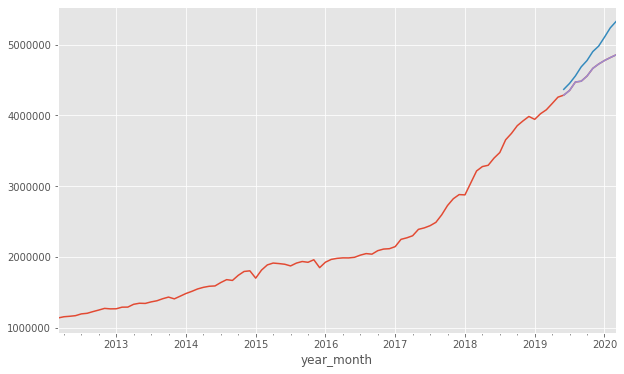

In [206]:
plt.figure(figsize=(10,6))

y.plot()
preds.plot()
y_test.plot()


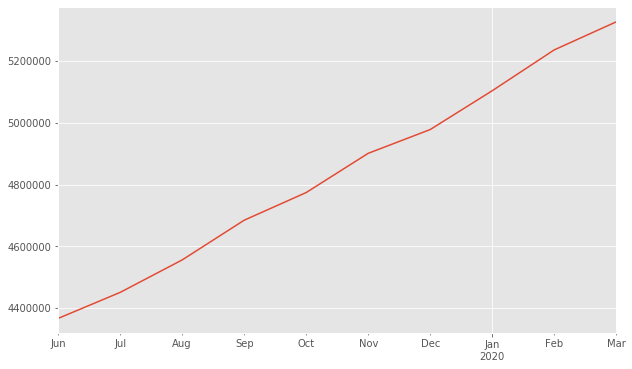

In [207]:
plt.figure(figsize=(10,6))

preds.plot()